### library import

In [31]:
import numpy as np
import scipy.misc as scm
from scipy.stats import poisson
import scipy.integrate as integrate
import math
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Modelingクラス

In [32]:
class Modeling:

    # ------------------理論に基づいた実装を行う------------------

    # 1,準備

    # Poisson過程
    # 単位時間あたりの到着数 λ
    # 時刻tまでにn人が到着する確率
    def poisson_possibility(self, n, t, lambda_poisson):
        return math.e**(-lambda_poisson * t) * (lambda_poisson * t)**n / math.factorial(n)

    # Gamma分布
    # 時刻tにn人目が到着する確率
    def gamma_possibility(self, n, t, lambda_poisson):
        return lambda_poisson**n * t**(n - 1) * math.e**(-lambda_poisson * t) / math.factorial(n - 1)

    # 多数決による判定精度
    # n人で多数決を行う場合の判定精度をacc(n)で表す
    # 個人の判定精度をpとする
    def acc_odd(self, n, p): # nが奇数2i-1のとき
        i = int((n + 1) / 2)
        acc = 0
        for j in range(i):
            acc += scm.comb(2 * i - 1, j) * p**(2 * i - 1 - j) * (1 - p)**j
        return acc

    def acc_even(self, n, p): # nが偶数2iのとき
        i = int(n / 2)
        acc = 0
        for j in range(i):
            acc += scm.comb(2 * i, j) * p**(2 * i - j) * (1 - p)**j
        acc += scm.comb(2 * i, i) * p**i * (1 - p)**i / 2
        return acc

    def acc(self, n, p):
        if n % 2 == 1:
            return self.acc_odd(n, p)
        else:
            return self.acc_even(n, p)

    # 2,単純な意見集約法

    # 2.1,時刻優先意見集約法
    # 時刻tまで待って多数決を行う
    # 効用を予測精度と所要時間の差で表す
    def time_priority_method(self, t, w, p, lambda_poisson):
        if t == 0: return 0 
        utility = 0
        for i in range(1, lambda_poisson * t, 1):
            utility += self.poisson_possibility(2 * i - 1, t, lambda_poisson) * self.acc_odd(2 * i - 1, p)
            utility += self.poisson_possibility(2 * i, t, lambda_poisson) * self.acc_even(2 * i, p)
        utility -= w * t
        return utility

    # 増減を調べる
    def inc_and_dec_time_priority_method(self, w, p, lambda_poisson):
        for t in range(1, 1000):
            diff = self.time_priority_method(t + 1, w, p, lambda_poisson) - self.time_priority_method(t, w, p, lambda_poisson)
            if diff < 0: return t

    # 2.2, 投票数優先意見集約法
    # n人集まるまで待って多数決を行う
    # 効用を予測精度と所要時間の差で表す
    def poll_priority_method(self, n, w, p, lambda_poisson):
        if n == 0: return 0
        utility = 0
        utility += self.acc(n, p)
        # 積分を行う
        value, abserr = integrate.quad(lambda t: w * t * self.gamma_possibility(n, t, lambda_poisson), 0, 1000)
        utility -= value
        return utility

    # 2.3, 得票数優先意見集約法
    # 先にk票集まった案に決定する
    # 効用を予測精度と所要時間の差で表す
    def vote_priority_method(self, k, w, p, lambda_poisson):
        if k == 0: return 0
        utility = 0
        for j in range(k, 2 * k):
            temp_possibility = scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p
            # 積分を行う
            value, abserr = integrate.quad(lambda t: w * t * self.gamma_possibility(j, t, lambda_poisson), 0, 1000)
            utility += temp_possibility * (1 - value)
        return utility
    
    # 3, 組み合わせ意見集約法
    # 方法1, 時刻T1まで待つ
    # 方法2, 投票者数がnに達すれば判定し終了、達しなければT1まで待つ
    # 方法3, 時刻T2(=< T1)までに投票者数がnに達すれば判定し終了、達しなければT1まで待つ(T2 = T1とすれば方法2と方法3は同じ)
    # 方法4, 得票者数がkに達すれば判定し終了、達しなければT1まで待つ
    # 方法5, 時間T2(=< T1)までに得票者数がkに達すれば判定を終了し、達しなければT1まで待つ (T2 = T1とすれば方法4と方法5は同じ)

    # 方法1(時刻優先意見集約法と同じ)
    def method1(self, t, w, p, lambda_poisson):
        return self.time_priority_method(t, w, p, lambda_poisson)

    # 方法2
    def method2(self, t1, n, w, p, lambda_poisson):
        if n == 0: return 0
        utility = 0
        for i in range(0, n):
            utility += self.poisson_possibility(i, t1, lambda_poisson) * (self.acc(i, p) - w * t1)
        # 積分を行う
        value, abserr = integrate.quad(lambda t: (self.acc(n, p) - w * t) * self.gamma_possibility(n, t, lambda_poisson), 0, t1)
        utility += value
        # 以下は必要か不明(おそらく不要)
        # for i in range(n + 1, 100):
        #     utility += self.poisson_possibility(i, t1, lambda_poisson) * (self.acc(n, p) - w * t1)
        return utility

    # 増減を調べる
    def inc_and_dec_time_method2(self, t1, w, p, lambda_poisson):
        for n in range(1, 50):
            diff = self.method2(t1, 2 * n + 1, w, p, lambda_poisson) - self.method2(t1, 2 * n - 1, w, p, lambda_poisson)
            if diff < 0:
                return 2 * n - 1
    
    # 方法3 時刻T2(=< T1)までに投票者数がnに達すれば判定し終了、達しなければT1まで待つ(T2 = T1とすれば方法2と方法3は同じ)
    def method3(self, t1, t2, n, w, p, lambda_poisson):
        if n == 0: return 0
        utility = 0
        for i in range(0, n):
            utility += self.poisson_possibility(i, t2, lambda_poisson) * (self.acc(i, p) - w * t2)
        # 積分を行う
        value, abserr = integrate.quad(lambda t: (self.acc(n, p) - w * t) * self.gamma_possibility(n, t, lambda_poisson), 0, t1)
        utility += value
        return utility
    
    # 方法4 得票者数がkに達すれば判定し終了、達しなければT1まで待つ
    def method4(self, t1, k, w, p, lambda_poisson):
        if k == 0: return 0
        utility = 0
        temp_integrand = 0
        # ----被積分関数を定義----
        def integrand_for_method4(t):
            integrand = 0
            for j in range(k, 2 * k):
                temp_possibility = scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p
                integrand += self.gamma_possibility(j, t, lambda_poisson) * temp_possibility * (1 - w * t)
            return integrand
        # --------終わり--------
        for i in range(0, k):
            for j in range(i, 2 * i):
                temp_possibility = scm.comb(j - 1, j - i) * p**(i - 1) * (1 - p)**(j - i) * p
                utility += self.poisson_possibility(i, t1, lambda_poisson) * temp_possibility * (1 - w * t1)
        #積分を行う
        value, abserr = integrate.quad(integrand_for_method4, 0, t1)
        utility += value
        return utility



### PlotGraphクラス

In [33]:
class PlotGraph:
    
    def __init__(self):
        sns.set_style("whitegrid")
    
    # ---------------------以下は理論に基づいた実装に対するグラフメソッド---------------------
    def plot_poisson(self, time, lambda_poisson):
        x_axis = np.linspace(0, 2 * time * lambda_poisson, 2 * time * lambda_poisson + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(m.poisson_possibility(x, time, lambda_poisson))
        plt.title('poisson time: {0} lambda: {1}'.format(time, lambda_poisson))
        plt.xlabel('people')
        plt.ylabel('possibility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_gamma(self, people, lambda_poisson):
        x_axis = np.linspace(0, 2 * people / lambda_poisson , 2 * people / lambda_poisson + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(m.gamma_possibility(people, x, lambda_poisson))
        plt.title('gamma people: {0} lambda: {1}'.format(people, lambda_poisson))
        plt.xlabel('time')
        plt.ylabel('possibility')
        plt.plot(x_axis, y_axis)
        plt.show()
    
    def plot_time_priority(self, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.time_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('time priority method weight: {0} person_possibility: {1}'.format(w, p))
        plt.xlabel('time')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_poll_priority(self, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.poll_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('poll priority method weight: {0} person_possibility: {1}'.format(w, p))
        plt.xlabel('require poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_vote_priority(self, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.poll_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('voge priority method weight: {0} person_possibility: {1}'.format(w, p))
        plt.xlabel('require vote people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()
    
    def plot_method1(self, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.time_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method1 weight: {0} person_possibility: {1}'.format(w, p))
        plt.xlabel('time')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method2(self, t1, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.method2(t1,int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method2 T1: {0} weight: {1} person_possibility: {2}'.format(t1, w, p))
        plt.xlabel('poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()
    
    def plot_method3(self, t1, t2, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.method3(t1, t2, int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method3 T1: {0} T2: {1} weight: {2} person_possibility: {3}'.format(t1, t2, w, p))
        plt.xlabel('poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()
        
    def plot_method4(self, t1, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.method4(t1,int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method2 T1: {0} weight: {1} person_possibility: {2}'.format(t1, w, p))
        plt.xlabel('require vote people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()



### main

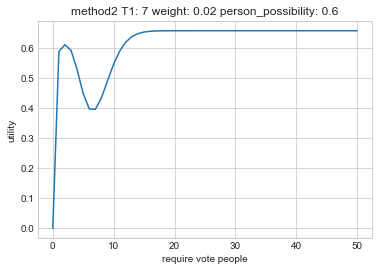

In [36]:
sns.set_style("whitegrid")
m = Modeling()
pg = PlotGraph()

# pg.plot_poisson(5,5)
# pg.plot_gamma(100,5)
# pg.plot_time_priority(0.02, 0.6, 1)
# pg.plot_poll_priority(0.02, 0.6, 1)
# pg.plot_vote_priority(0.02, 0.6, 1)
# pg.plot_method1(0.02, 0.6, 1)
# pg.plot_method2(20, 0.02, 0.6, 1)
# pg.plot_method3(15, 10, 0.02, 0.6, 1)
pg.plot_method4(7, 0.02, 0.6, 1)


# sns.set_style("whitegrid")
# pg = PlotGraph(50, 2)
# pg.plot_error_possibility_graph(5)
# pg.plot_error_possibility_graph_by_people_num()
# pg.plot_utility_possibility_average_graph(11, 13, 17, 0.5)
# pg.plot_utility_possibility_variance_graph(11, 13, 17, 0.5)
# pg.plot_utility_weight_average_graph(0.7, 11, 13, 17)
# pg.plot_utility_weight_variance_graph(0.7, 11, 13, 17)
# pg.plot_utility_possibility_average_graph_for_single_method(0.5)
# pg.plot_utility_possibility_variance_graph_for_single_method(0.5)
# pg.plot_utility_weight_average_graph_with_uniform_distribution(50, 50, 11, 13, 17)
# pg.plot_utility_weight_variance_graph_with_uniform_distribution(50, 50, 11, 13, 17)
# pg.plot_utility_weight_average_graph_with_uniform_distribution_for_single_method(50, 50)
# pg.plot_utility_weight_variance_graph_with_uniform_distribution_for_single_method(50, 50)